 ### ガウス過程
 
 これまで見てきた全てのモデルはパラメトリックモデルでした。ノンパラメトリックモデル(Non-parameteric)とはパラメータの数がデータとともに増加するモデルのことを言います。言い換えると、ノンパラメトリックモデルは潜在的に無限のパラメータを持ったモデルです。
 
 正規分布の式を無限次元に拡張する方法と、**関数の分布(distribution over function)**を学ぶ方法を調べることで、カーネルの例を見ていきましょう。
 
 
 #### カーネルベースモデル
 カーネルは、比較的簡単に計算でき、柔軟な非線型モデルの基礎として使えるからです。カーネルはいくらか異なる数学的な特性を持っています。ベイジアンの議論の目的からすると、基本的には、カーネルは二つの入力から常に正の値を一つ出力する対称関数と言えるでしょう。この見方をすると、二つの入力間の類似度を表すものとして、カーネル関数の出力を解釈することができます。
 
 いくつかの有益なカーネルが存在します。画像認識や文書解析といった個別の問題に特化しているものもあれば、周期関数をモデリングするに適したものもあります。
 

In [1]:
import arviz as az
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 58
az.style.use(['arviz-darkgrid'])
np.set_printoptions(precision=2)

Text(0, 0.5, '$y$')

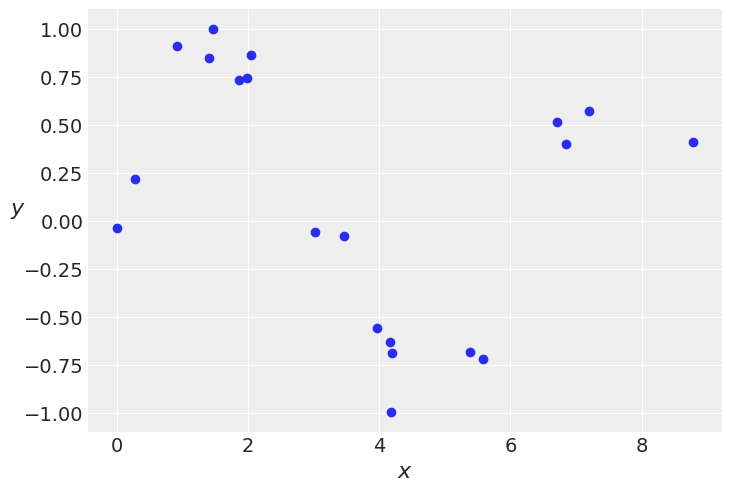

In [5]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$',fontsize=16, rotation=0)

In [3]:
def gauss_kernel(x, n_knots):
    knots = np.linspace(x.min(), x.max(), n_knots)
    w = 2
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, gamma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 15 seconds.
/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'gamma\n0'}>,
        <AxesSubplot:title={'center':'gamma\n0'}>],
       [<AxesSubplot:title={'center':'gamma\n1'}>,
        <AxesSubplot:title={'center':'gamma\n1'}>],
       [<AxesSubplot:title={'center':'gamma\n2'}>,
        <AxesSubplot:title={'center':'gamma\n2'}>],
       [<AxesSubplot:title={'center':'gamma\n3'}>,
        <AxesSubplot:title={'center':'gamma\n3'}>],
       [<AxesSubplot:title={'center':'gamma\n4'}>,
        <AxesSubplot:title={'center':'gamma\n4'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

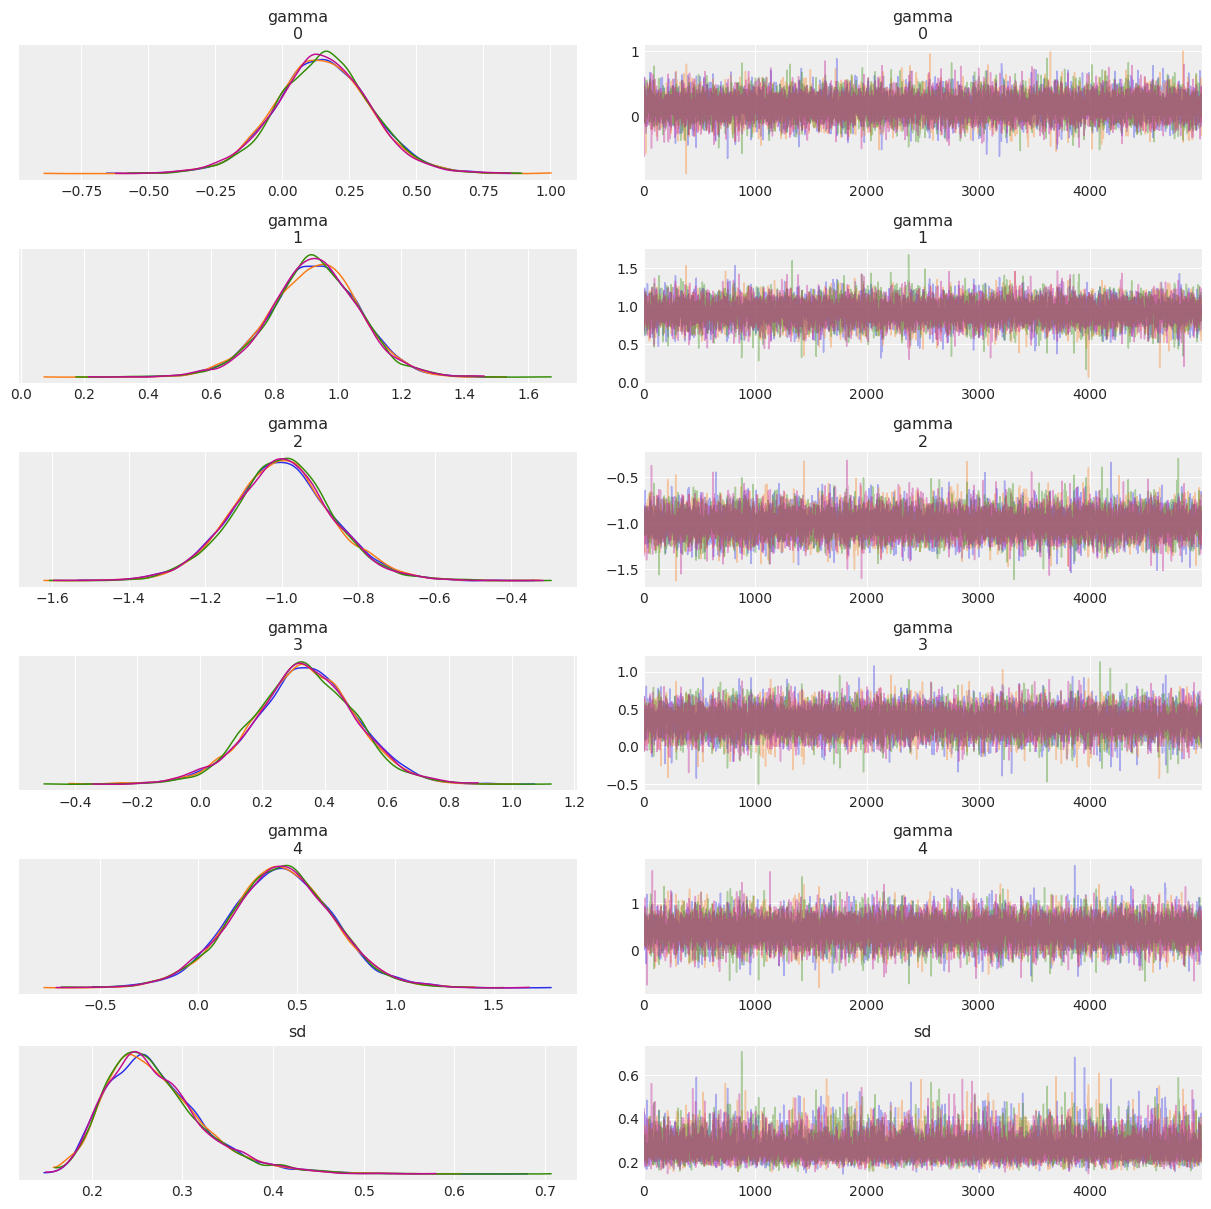

In [19]:
n_knots = 5

with pm.Model() as kernel_model:
    gamma= pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd', 0, 10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    y1 = pm.Normal('y1', mu=mu, sd=sd, observed=y)
    
    kernel_trace = pm.sample(5000)

az.plot_trace(kernel_trace)

/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0, 0.5, '$f(x)$')

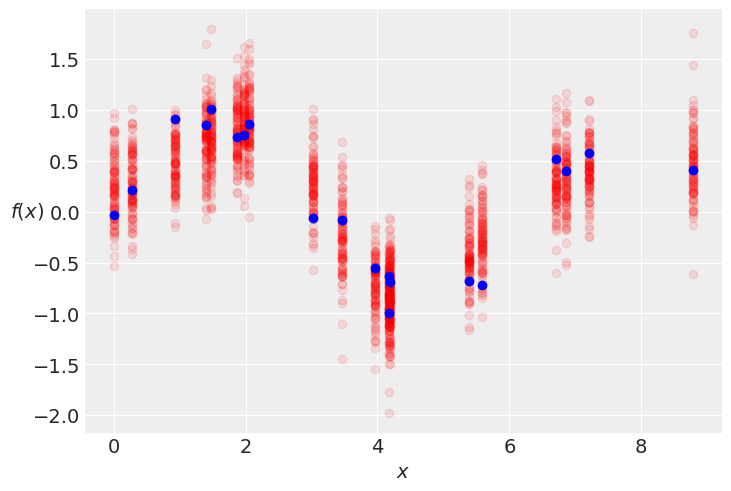

In [21]:
# 事後予測チェック
ppc = pm.sample_posterior_predictive(kernel_trace, model=kernel_model, random_seed=RANDOM_SEED, samples=100)
plt.plot(x, ppc['y1'].T, 'ro', alpha=0.1)

plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$f(x)$', fontsize=14, rotation=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, gamma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


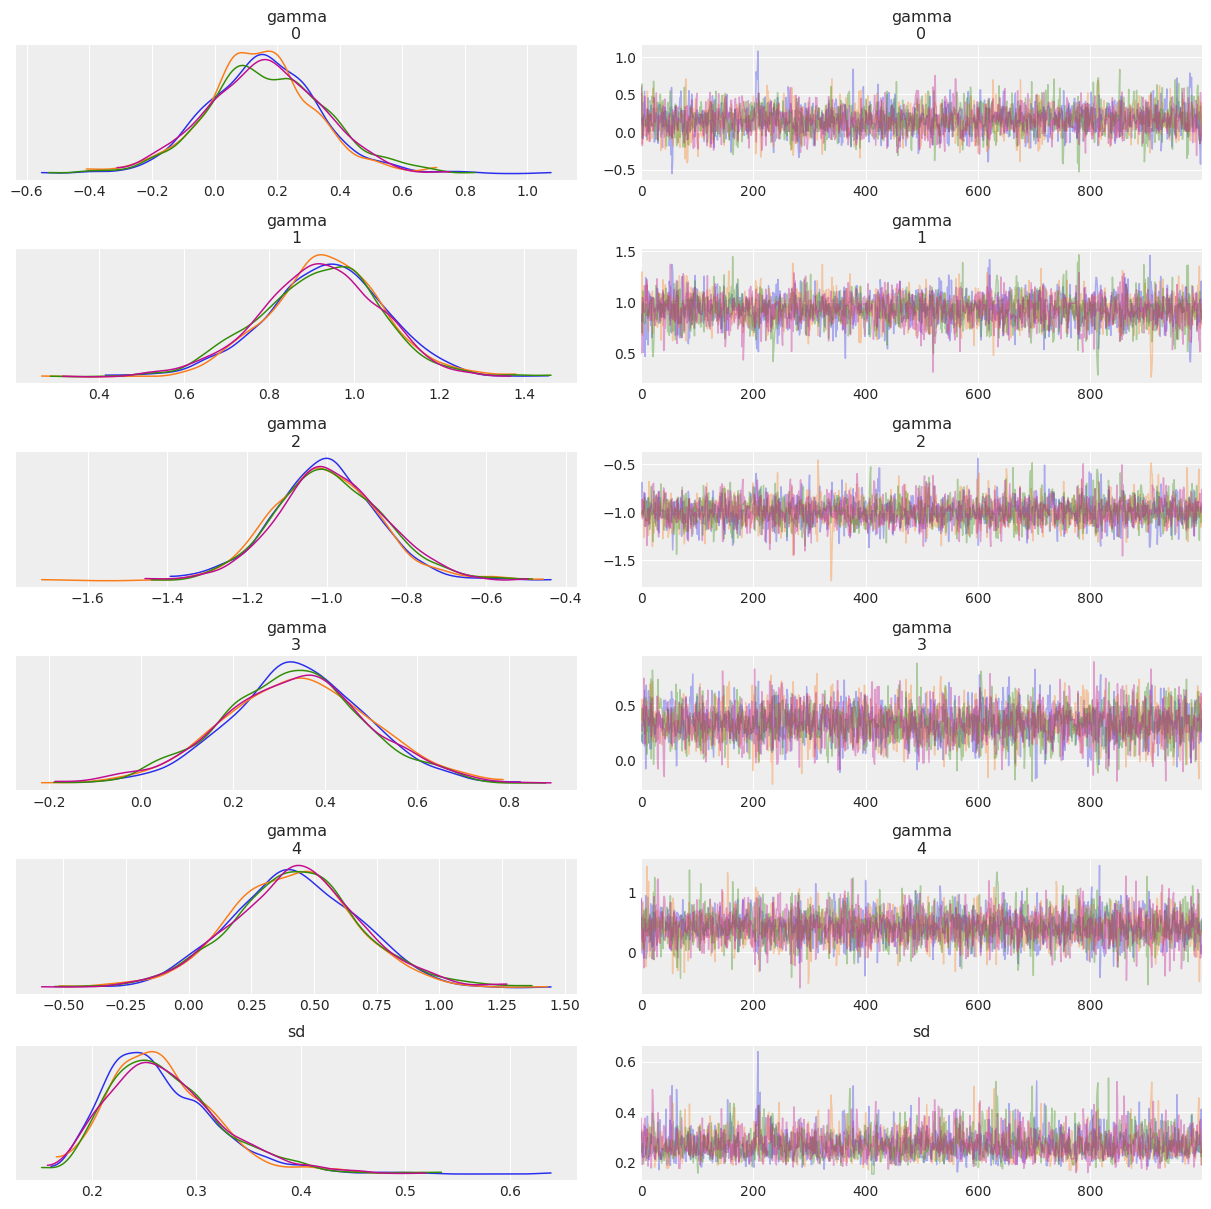

In [22]:
with kernel_model:
    trace_1 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
az.plot_trace(trace_1);

In [23]:
with kernel_model:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=['y1'], random_seed=RANDOM_SEED
    )

/Users/narenbao/anaconda3/envs/op/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:xlabel='y1'>

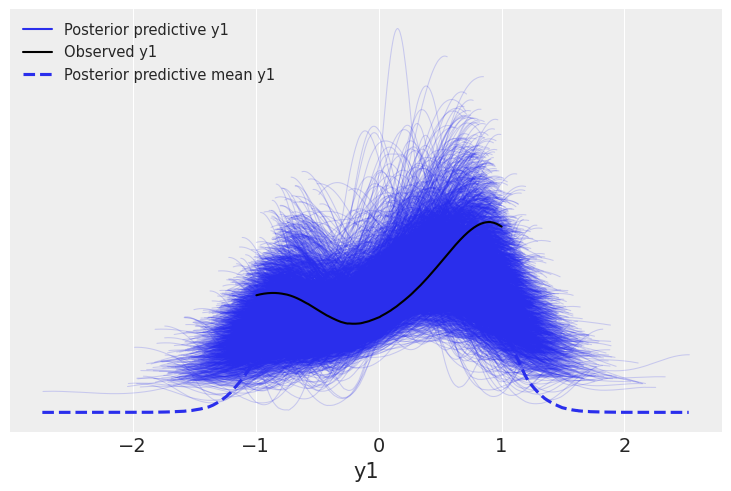

In [24]:
idata = az.from_pymc3(trace_1, posterior_predictive=ppc)
az.plot_ppc(idata)

Text(0, 0.5, '$f(x)$')

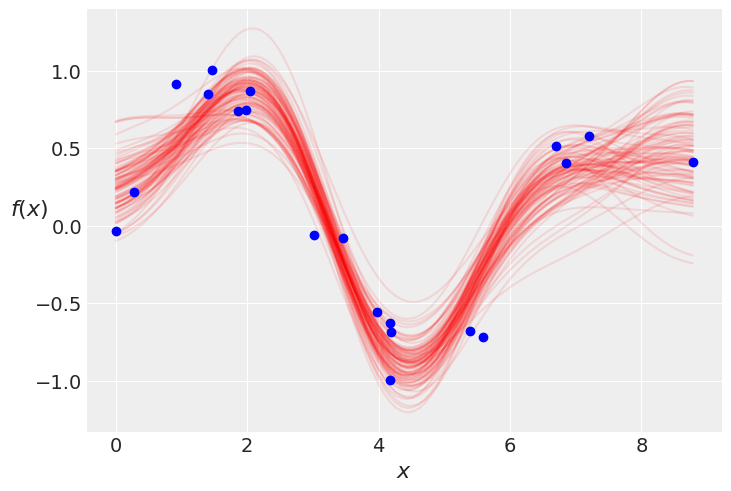

In [26]:
new_x =np.linspace(x.min(), x.max(), 100)
k = gauss_kernel(new_x, n_knots)
gamma_pred = kernel_trace['gamma']
for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'r-', alpha=0.1)

plt.plot(x, y, 'bo')
plt.plot(x, mean(y_pred), 'bo')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)